# Recurrent Neural Network Models

* It is evident that the given data set has a **sequential structure** to it. Based on our previous experience, RNN models like **LSTMs** (Long-Short Term Memory) are great at capturing sequetial relations in data. 

* We use Standard Scaling for input(X) and Min-Max Scaling for output(Y).

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.



In [1]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization, LSTM, Bidirectional
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

In [16]:
Y=Y.T
print(np.shape(X),np.shape(Y))

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std


Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

#Standard Scaling of Y
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

'''
#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max
'''

X=np.reshape(X,(-1,38,1))

#xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
#print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(1070107, 38) (1070107, 15)


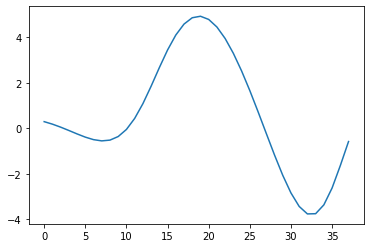

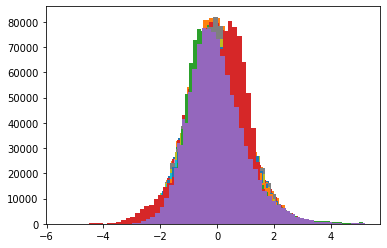

In [17]:
plt.plot(X[10000,:])
plt.show()
for i in range(15):
    plt.hist(Y[:,i],bins=50)
plt.show()

In [19]:
model = keras.Sequential()

model.add(Bidirectional(LSTM(100), input_shape=(38,1)))
model.add(Dropout(0.2))

#model.add(Flatten())
model.add(Dense(600, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(15, activation='linear')) #sigmoid

model.compile(loss='mse', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 200)               81600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 600)               120600    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 600)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 600)               2400      
_________________________________________________________________
dropout_5 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)               

In [20]:
history = model.fit(X, Y, batch_size=256, epochs=5, validation_split=0.1,
                    callbacks=[keras.callbacks.TerminateOnNaN()], shuffle=False)

Train on 945049 samples, validate on 105006 samples
Epoch 1/5
945049/945049 [==============================] - 868s 918us/step - loss: 0.7353 - accuracy: 0.2471 - val_loss: 0.6024 - val_accuracy: 0.3030
Epoch 2/5
945049/945049 [==============================] - 835s 883us/step - loss: 0.6119 - accuracy: 0.2964 - val_loss: 0.5806 - val_accuracy: 0.3132
Epoch 3/5
945049/945049 [==============================] - 870s 920us/step - loss: 0.5945 - accuracy: 0.3065 - val_loss: 0.5714 - val_accuracy: 0.3190
Epoch 4/5
945049/945049 [==============================] - 869s 919us/step - loss: 0.5861 - accuracy: 0.3121 - val_loss: 0.5630 - val_accuracy: 0.3246
Epoch 5/5
945049/945049 [==============================] - 876s 927us/step - loss: 0.5816 - accuracy: 0.3160 - val_loss: 0.5602 - val_accuracy: 0.3280


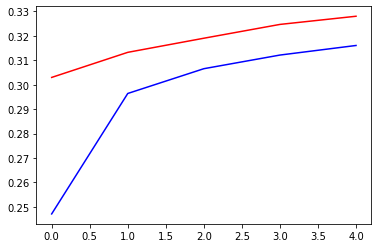

In [24]:
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.show()

In [22]:
Y_hat=model.predict(X)

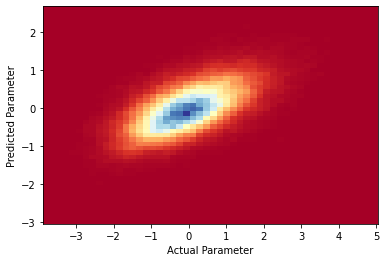

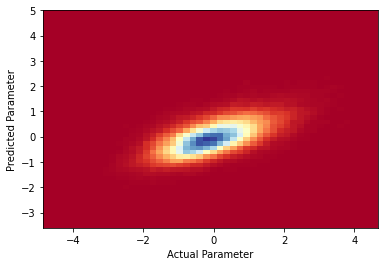

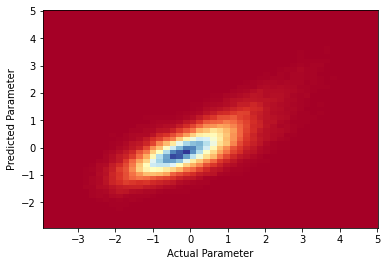

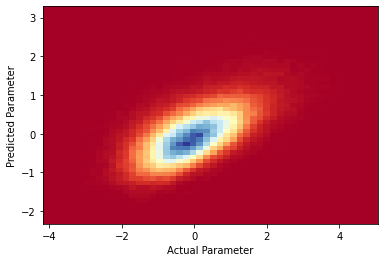

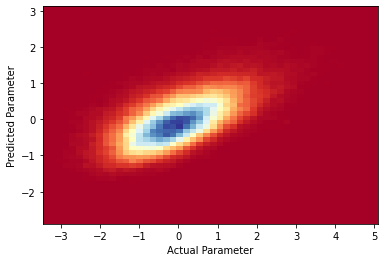

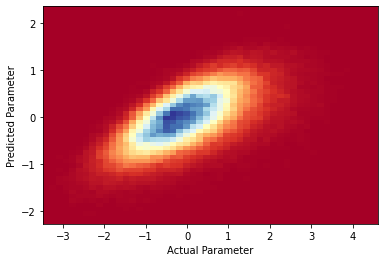

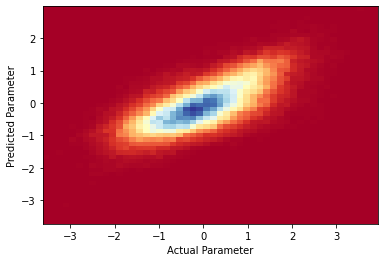

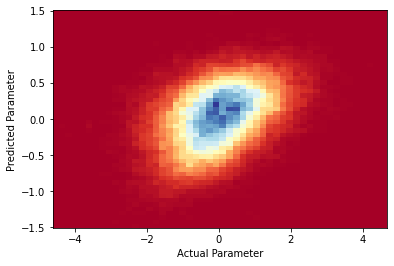

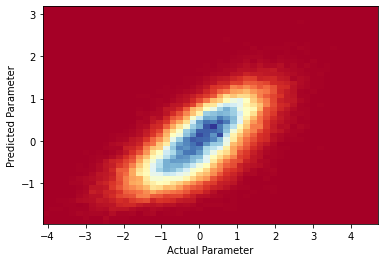

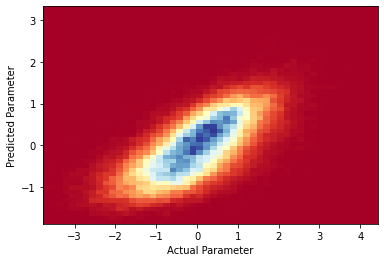

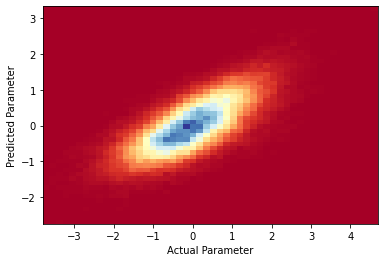

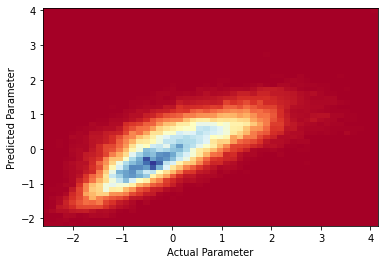

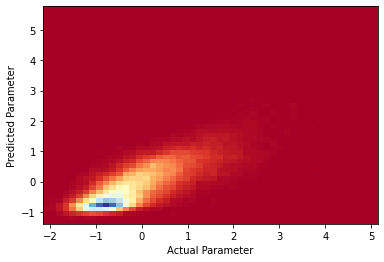

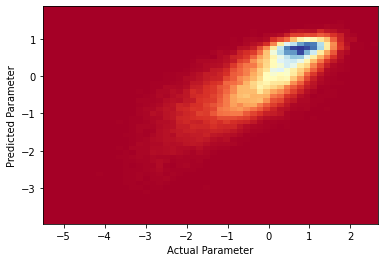

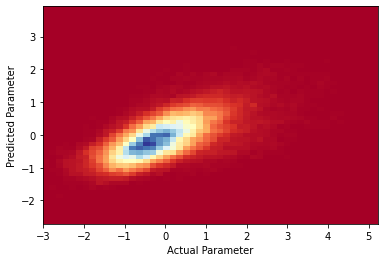

In [23]:
from matplotlib import cm

for i in range(15):
  plt.hist2d(Y[:,i],Y_hat[:,i],bins=50,cmap=cm.RdYlBu)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  #plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
  plt.show()

In [25]:
from sklearn.metrics import r2_score 
for i in range(15):
  print(np.round(r2_score(Y[:,i], Y_hat[:,i]),3),end='\t')

0.351	0.376	0.539	0.374	0.381	0.376	0.483	0.16	0.475	0.468	0.511	0.541	0.583	0.589	0.398	

$R^2$ Test: \\
with return_sequence (small_net): \\
[0.326	0.346	0.513	0.352	0.362	0.369	0.444	0.141	0.458	0.450	0.494	0.501	0.522	0.558	0.369] \\
without return_sequence: (Min_Max Scaling of Y) \\
[0.331	0.359	0.525	0.365	0.374	0.376	0.473	0.154	0.463	0.454	0.505	0.529	0.571	0.569	0.385] \\
without return sequence (Mean_Std Scaling of Y) \\
[0.351	0.376	0.539	0.374	0.381	0.376	0.483	0.160	0.475	0.468	0.511	0.541	0.583	0.589	0.398]